In [1]:
import os.path
from gensim import corpora
from gensim.models import LsiModel
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import re


C:\Users\josem\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
from spacy.lang.es import Spanish
import spacy
nlp = spacy.load("es_core_news_sm")

def limpiar_puntuacion(tweet):
    frase_limpia = ""
    doc = nlp(tweet)
    for token in doc:
        if token.pos_ != "PUNCT":
            frase_limpia = frase_limpia + " " + token.text
    return frase_limpia

def limpiar_verbos(tweet):
    frase_limpia = ""
    doc = nlp(tweet)
    for token in doc:
        texto_minuscula =token.text.lower()
        if not (token.pos_ == "VERB" and (texto_minuscula.startswith("sab") or texto_minuscula.startswith("quer") or texto_minuscula.startswith("gust"))):
            frase_limpia = frase_limpia + " " + token.text
    return frase_limpia

def RemoveAt(text):
    regex= r"@\w+"
    text = re.sub(regex,"",text)
    return text

def RemoveHashtag(text):
    regex= r"#\w+" 
    text = re.sub(regex,"",text)
    return text

def RemoveNumbers(text):
    regex= r'\d+'
    text = re.sub(regex,"",text)
    return text

def RemoveHyphen(text):
    regex= r"\-" 
    text = re.sub(regex,"",text)
    text = text.rstrip('\n')
    return text

def RemoveBarraBaja(text):
    regex= r"\_" 
    text = re.sub(regex,"",text)
    text = text.rstrip('\n')
    return text

def limpiar(tweet):
    tweet=RemoveAt(tweet)
    tweet=RemoveHashtag(tweet)
    tweet=RemoveNumbers(tweet)
    tweet=RemoveHyphen(tweet)
    tweet=RemoveBarraBaja(tweet)
    tweet=limpiar_puntuacion(tweet)
    tweet=limpiar_verbos(tweet)    
    return tweet

C:\Users\josem\anaconda3\lib\site-packages\spacy\util.py:833: UserWarning: [W095] Model 'es_core_news_sm' (3.0.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.2.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [3]:
def load_data(path,file_name):

    documents_list = []
    titles=[]
    ruta_fichero = path + file_name
    with open(ruta_fichero, mode="r", encoding="utf-8") as fp:
        for line in fp.readlines():
            text = limpiar(line)
            documents_list.append(text)
            text = line.strip()
                   
    print("Número total de documentos:",len(documents_list))
    titles.append( text[0:min(len(text),1000)] )
    return documents_list,titles

In [4]:
stopwords = stopwords.words('spanish')
with open ("stopwords.txt", mode="r", encoding="utf-8") as newSWlist:
    for nuevapalabra in newSWlist.readlines():
        palabritas = nuevapalabra.strip()
        stopwords.append(palabritas)

In [5]:
def preprocess_data(doc_set):
        tokenizer = RegexpTokenizer(r"\w+")
        texts = []
        for i in doc_set:
            raw = i.lower()
            tokens = tokenizer.tokenize(raw)
            stopped_tokens = [i for i in tokens if not i in stopwords]
            texts.append(stopped_tokens)
        return texts

In [6]:
def prepare_corpus(doc_clean):
    dictionary = corpora.Dictionary(doc_clean)
    dictionary.filter_extremes(no_below=20, no_above=0.5, keep_n=100000)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    return dictionary,doc_term_matrix

In [7]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [8]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [9]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [10]:
# LSA Model
number_of_topics=7
words=10
document_list,titles=load_data("","tweets.txt")
clean_text=preprocess_data(document_list)
model=create_gensim_lsa_model(clean_text,number_of_topics,words)

Número total de documentos: 9704
[(0, '-0.491*"coma" + -0.305*"verbo" + -0.232*"frase" + -0.214*"punto" + -0.197*"oración" + -0.184*"expresión" + -0.182*"mayúscula" + -0.162*"después" + -0.154*"persona" + -0.132*"palabras"'), (1, '-0.565*"covid" + 0.544*"coma" + -0.399*"verbo" + 0.200*"punto" + -0.187*"expresión" + -0.138*"persona" + 0.125*"después" + -0.095*"palabras" + 0.073*"tras" + -0.069*"virus"'), (2, '-0.769*"covid" + 0.490*"verbo" + -0.265*"coma" + 0.123*"persona" + -0.101*"punto" + -0.091*"virus" + 0.071*"conjugación" + -0.066*"después" + 0.063*"frase" + 0.058*"presidente"'), (3, '-0.528*"verbo" + 0.385*"mayúscula" + -0.343*"coma" + 0.318*"expresión" + 0.277*"palabras" + -0.213*"covid" + 0.171*"minúscula" + 0.154*"tilde" + 0.125*"solo" + 0.116*"nombre"'), (4, '-0.847*"expresión" + 0.337*"mayúscula" + 0.205*"palabras" + 0.141*"minúscula" + -0.106*"coma" + 0.099*"frase" + 0.099*"nombre" + 0.080*"inicial" + 0.078*"verbo" + 0.067*"deben"'), (5, '-0.851*"frase" + 0.290*"mayúscula" 

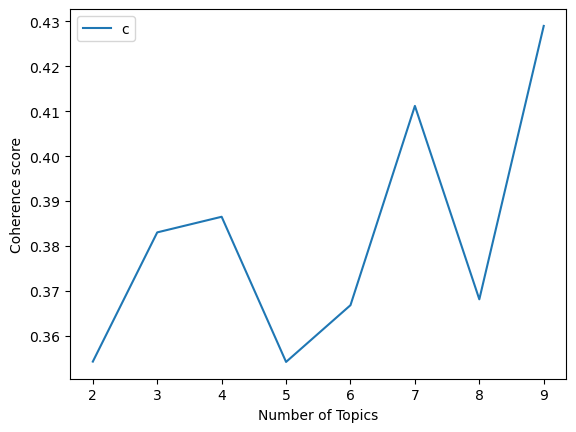

In [11]:
start,stop,step=2,10,1
plot_graph(clean_text,start,stop,step)

In [12]:
# from nltk import FreqDist
# frecuencias = FreqDist(tokens)
# frecuencias.plot(15, cumulative = False) #esto saca un grafico

In [13]:
tokens = []
for e in clean_text:
    for a in e:
        tokens.append(a)
tokens = [token for token in tokens if token not in stopwords]
Ntokens = len(tokens)
Ntipos = len(set(tokens)) #conjunto de los tokens
print (Ntokens)
print (Ntipos)
diversidad = Ntipos/Ntokens
numero_de_tweets = len(document_list)
print ("La diversidad léxica del texto es del", (diversidad*100),"%")
print ("El número de palabras con significado por tweet es de", Ntokens/numero_de_tweets)

81390
18474
La diversidad léxica del texto es del 22.698120162182086 %
El número de palabras con significado por tweet es de 8.387262984336356


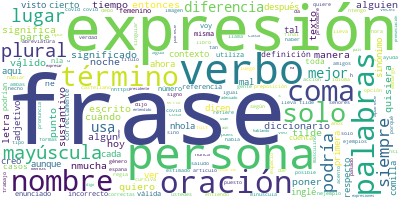

In [14]:
from wordcloud import WordCloud
    # Join the different processed titles together.
long_string = ','.join(list(tokens))
    # Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
wordcloud.generate(long_string)
    # Visualize the word cloud
wordcloud.to_image()